current_x :  4.194346785545349
current_y :  4.201093792915344
desired_x :  4.242640495300293
desired_y :  4.242640495300293
joint1_angle:  35.76430119144675
joint2_angle:  20.245449096199422
joint3_angle:  -12.619643633170455


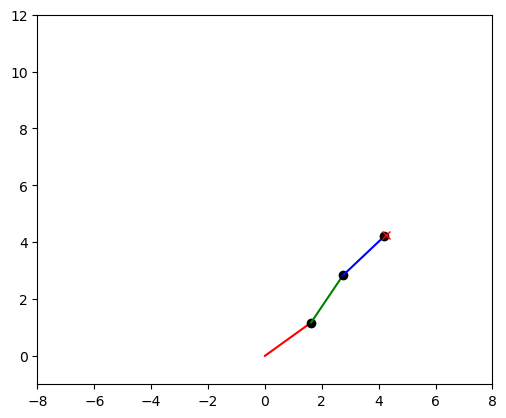

In [29]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt

def forward_kinematics(theta1, theta2, theta3, l1=2, l2=2, l3=2):
    x = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2) + l3*np.cos(theta1 + theta2 + theta3)
    y = l1*np.sin(theta1) + l2*np.sin(theta1 + theta2) + l3*np.sin(theta1 + theta2 + theta3)
    theta = theta1 + theta2 + theta3

    return x, y, theta

def rad_to_deg(radians):
    degrees = radians * (180 / pi)
    degrees = (degrees + 180) % 360 - 180
    return degrees

class RoboticArmEnv(gym.Env):
    def __init__(self):
        super(RoboticArmEnv, self).__init__()

        #state-space [current_x, current_y, desired_x, desired_y, joint1_angle, joint2_angle, joint3_angle]

        self.action_space = spaces.Box(low=-0.3, high=0.3, shape=(3,), dtype=np.float64)  # Joint angle changes
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float64)  # State space

        self.arm_length = [2, 2, 2]  # Length of links

        # Initialize state
        self.current_position = np.array([0, 0], dtype=np.float64)  # Initial end-effector position
        self.desired_position = np.array([6/sqrt(2), 6/sqrt(2)], dtype=np.float64)  # Desired end-effector position
        self.joint_angles = np.array([0, 0, 0], dtype=np.float64)   # Initial joint angles

    def step(self, action):
        # print((action))
        # print(self.joint_angles)
        self.joint_angles += action

        x, y, _ = forward_kinematics(self.joint_angles[0], self.joint_angles[1], self.joint_angles[2])
        self.current_position = np.array([x, y], dtype=np.float64)

        # Calculate reward based on distance to desired position
        reward = -np.linalg.norm(self.current_position - self.desired_position)

        # Check if the episode is done
        done = np.linalg.norm(self.current_position - self.desired_position) < 0.1

        # Return state, reward, done, info
        return self._get_obs(), reward, done, {}

    def reset(self):
        # Reset arm to initial state
        self.current_position = np.array([0, 0], dtype=np.float32)
        self.desired_position = np.array([6/sqrt(2), 6/sqrt(2)], dtype=np.float32)
        self.joint_angles = np.array([0, 0, 0], dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        # Return current state
        return np.concatenate((self.current_position, self.desired_position, self.joint_angles))

if __name__ == "__main__":
    env = RoboticArmEnv()
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward

        # print("Action:", action, "Observation:", obs, "Reward:", reward)
    # print("Total Reward:", total_reward)
    for i, j in zip(['current_x', 'current_y', 'desired_x', 'desired_y', 'joint1_angle', 'joint2_angle', 'joint3_angle'], obs):
        
        if i == 'joint1_angle':
            print("joint1_angle: ", rad_to_deg(j))
        elif i == 'joint2_angle':
            print("joint2_angle: ", rad_to_deg(j))
        elif i == 'joint3_angle':
            print("joint3_angle: ", rad_to_deg(j))
        else:
            print(i, ": ", j)

    # print(obs)
    # print(obs[-3:])
    

    joint_angles = obs[-3:]

    desired_position = obs[2:4]
    arm_length = [2, 2, 2]
    plt.figure()
    plt.plot([0, arm_length[0]*np.cos(joint_angles[0])],
                [0, arm_length[0]*np.sin(joint_angles[0])], 'r-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0])],
                [arm_length[0]*np.sin(joint_angles[0])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'g-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'b-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'ko')
    plt.plot(desired_position[0], desired_position[1], 'rx')
    plt.xlim(-8, 8)
    plt.ylim(-1, 12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()  